<a href="https://colab.research.google.com/github/susana1mejia/Deep-Learning-Proyect/blob/main/Arquitectura_de_linea_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Arquitectura red neuronal ###

In [2]:
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU, LeakyReLU
from tensorflow.keras.callbacks import Callback
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
with open('structure_data_target.s','rb') as file:
  structure_data_target = pickle.load(file)

with open('structure_data_3D.s','rb') as file:
  structure_data_3D = pickle.load(file)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(structure_data_3D, structure_data_target, test_size=.15)

In [5]:
print(X_train.shape, X_test.shape, Y_test.shape, Y_train.shape)

(121, 14, 200) (22, 14, 200) (22,) (121,)


In [6]:
X_train.astype(np.float32)
Y_train.astype(np.float32)
X_test.astype(np.float32)
Y_test.astype(np.float32)

array([1.   , 0.   , 1.   , 1.   , 1.   , 1.   , 0.215, 1.   , 0.   ,
       0.   , 0.115, 0.615, 1.   , 0.19 , 1.   , 0.   , 0.   , 0.   ,
       0.   , 1.   , 0.295, 1.   ], dtype=float32)

Creación de arquitectura para un modelo secuencial

In [7]:
def get_model(X_train, layer_type):

  model = Sequential()
  init1k = keras.initializers.RandomNormal(mean=.5, stddev=0.5, seed=1)

  if layer_type=='SimpleRNN':
    model.add(SimpleRNN(350, activation = 'relu', return_sequences=True, bias_initializer=init1k, input_shape = (X_train.shape[1],X_train.shape[2]), name = 'RNN_1'))
    model.add(SimpleRNN(350, activation = 'relu', name = 'RNN_2'))
    model.add(RepeatVector(250, name = 'Repeat_Vector_1'))
    model.add(SimpleRNN(250, activation = 'relu', return_sequences=True, name = 'RNN_3'))
    model.add(SimpleRNN(100, activation = 'relu',return_sequences=True, name = 'RNN_4'))
    model.add(Dense(60, activation = 'relu', name = 'Dense_3'))
    model.add(Dense(40, activation = 'relu', name = 'Dense_1'))
    model.add(Dense(1, activation = 'sigmoid', name = 'Dense_2'))

  if layer_type == 'LSTM':
    model.add(LSTM(200,activation = 'relu', return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(100, activation = 'relu'))
    model.add(RepeatVector(100))
    model.add(LSTM(10,return_sequences=True, activation = 'relu'))
    model.add((Dense(1, activation = 'sigmoid')))

  if layer_type == 'GRU':
    model.add(GRU(200,activation = 'relu',return_sequences=True, input_shape=((X_train.shape[1],X_train.shape[2]))))
    model.add(GRU(50,activation = 'relu'))
    model.add(RepeatVector(50))
    model.add(GRU(150, return_sequences = True, activation = 'relu'))
    model.add(GRU(100, activation = 'relu'))
    model.add((Dense(1,activation = 'sigmoid')))
  return model



In [276]:
model = get_model(X_train,'SimpleRNN')
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN_1 (SimpleRNN)           (None, 14, 350)           192850    
                                                                 
 RNN_2 (SimpleRNN)           (None, 350)               245350    
                                                                 
 Repeat_Vector_1 (RepeatVect  (None, 250, 350)         0         
 or)                                                             
                                                                 
 RNN_3 (SimpleRNN)           (None, 250, 250)          150250    
                                                                 
 RNN_4 (SimpleRNN)           (None, 250, 100)          35100     
                                                                 
 Dense_3 (Dense)             (None, 250, 60)           6060      
                                                     

Funciones de callback para revisar el comportamiento de los pesos y las activaciones

In [243]:
def LayerWeightsCallback(layer_name):
    class LayerWeightsCallback_class(Callback):

        def __init__(self, layer_name):
            super().__init__()
            self.mean_per_epoch = []
            self.std_per_epoch = []
            self.max_per_epoch = []
            self.layer_name = layer_name

        def on_epoch_end(self, epoch, logs=None):
          if self.layer_name != 'Repeat_Vector_1':
            w = self.model.get_layer(self.layer_name).get_weights()[0] 
            self.mean_per_epoch.append(np.mean(w)) 
            self.std_per_epoch.append(np.std(w)) 
            self.max_per_epoch.append(np.max(w))
    
    return LayerWeightsCallback_class(layer_name)

In [251]:
def TrainValActivationsCallback(layer_name, X):
    class TrainValActivationsCallback_class(Callback):

        def __init__(self, layer_name, X):
            super().__init__()
            self.mean_per_epoch = []
            self.std_per_epoch = []
            self.layer_name = layer_name
            self.X = X

        def on_epoch_end(self, epoch, logs=None):

            layer = self.model.get_layer(self.layer_name) # find layer
            model = Model([self.model.input], [layer.output])
            a = model(self.X)                               # feed self.X into self.model and get the activations at layer_name
            self.mean_per_epoch.append(np.mean(a))  # append to self.mean_per_epoch the activations mean 
            self.std_per_epoch.append(np.std(a))   # append to self.std_per_epoch the activations std 
    
    return TrainValActivationsCallback_class(layer_name, X)

In [259]:
def plot_epochs(cbset, title=""):
    cm = plt.cm.Greens
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    for i,cb in enumerate(cbset):
        plt.plot(cb.mean_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
        plt.xlabel("epochs"); plt.grid(); plt.title(title+" mean")
    plt.subplot(132)
    for i,cb in enumerate(cbset):
        plt.plot(cb.std_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
        plt.xlabel("epochs"); plt.grid(); plt.title(title+" std")
    # plt.subplot(133)
    # for i,cb in enumerate(cbset):
    #     plt.plot(cb.max_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
    #     plt.xlabel("epochs"); plt.grid(); plt.title(title+" max value")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [277]:
model.compile(optimizer = 'adam',loss = 'mse', metrics = ['accuracy'])

# model.get_layer('RNN_1').layer_type()

cbs = [LayerWeightsCallback(i.name) for i in model.layers]
model.fit(X_train, Y_train, epochs = 100, validation_data = (X_test, Y_test), callbacks = cbs)

Epoch 1/100
4/4 [==============================] - 7s 809ms/step - loss: 0.3381 - accuracy: 0.3229 - val_loss: 0.3721 - val_accuracy: 0.4091
Epoch 2/100
4/4 [==============================] - 4s 970ms/step - loss: 0.3123 - accuracy: 0.3636 - val_loss: 0.2572 - val_accuracy: 0.3644
Epoch 3/100
4/4 [==============================] - 2s 594ms/step - loss: 0.2205 - accuracy: 0.3311 - val_loss: 0.2115 - val_accuracy: 0.4091
Epoch 4/100
4/4 [==============================] - 2s 607ms/step - loss: 0.2109 - accuracy: 0.3143 - val_loss: 0.2145 - val_accuracy: 0.4091
Epoch 5/100
4/4 [==============================] - 2s 595ms/step - loss: 0.2159 - accuracy: 0.3636 - val_loss: 0.2138 - val_accuracy: 0.4091
Epoch 6/100
4/4 [==============================] - 3s 679ms/step - loss: 0.2048 - accuracy: 0.3636 - val_loss: 0.2134 - val_accuracy: 0.4091
Epoch 7/100
4/4 [==============================] - 4s 804ms/step - loss: 0.2012 - accuracy: 0.3641 - val_loss: 0.2118 - val_accuracy: 0.4091
Epoch 8/100
4

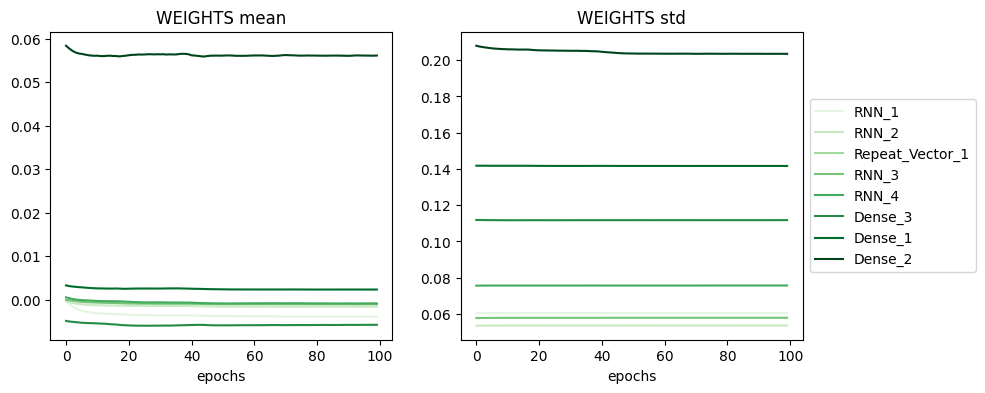

In [278]:
plot_epochs(cbs, "WEIGHTS")

In [255]:
cbs_train = [TrainValActivationsCallback(i.name, X_train) for i in model.layers]
cbs_test  = [TrainValActivationsCallback(i.name, X_test) for i in model.layers]

model.fit(X_train, Y_train, epochs = 200, validation_data = (X_test, Y_test), callbacks = cbs_train+cbs_test, batch_size=10)

Epoch 1/200
13/13 [==============================] - 18s 1s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 2/200
13/13 [==============================] - 19s 2s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 3/200
13/13 [==============================] - 16s 1s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 4/200
13/13 [==============================] - 17s 1s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 5/200
13/13 [==============================] - 16s 1s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 6/200
13/13 [==============================] - 16s 1s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 7/200
13/13 [==============================] - 16s 1s/step - loss: 0.2004 - accuracy: 0.3636 - val_loss: 0.2113 - val_accuracy: 0.4091
Epoch 8/200
1

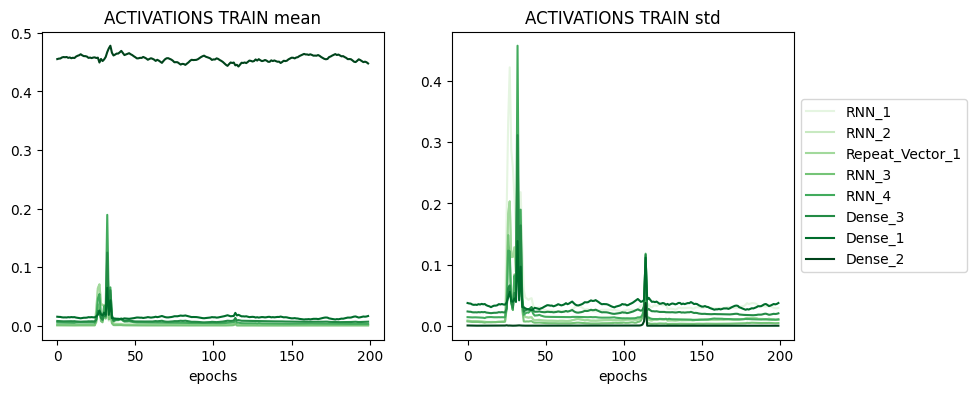

In [260]:
plot_epochs(cbs_train, "ACTIVATIONS TRAIN")

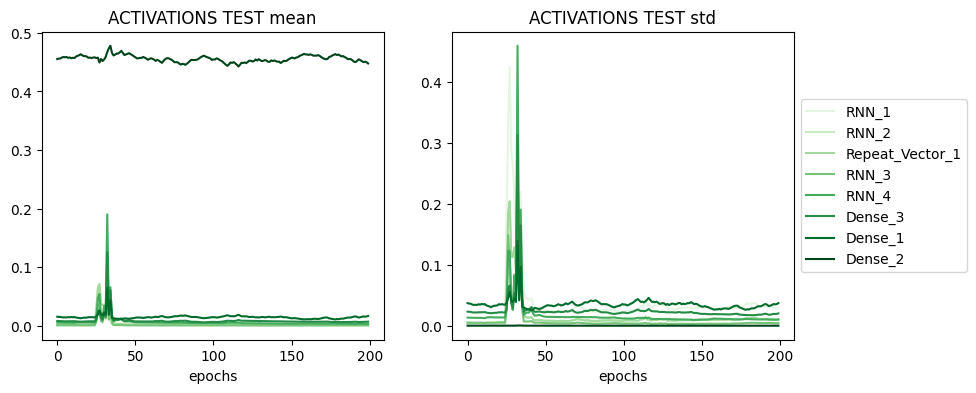

In [261]:
plot_epochs(cbs_test, "ACTIVATIONS TEST")

In [279]:
y_pred = model.predict(X_test).argmax(axis=1)
y_pred.shape


1/1 [==============================] - 1s 660ms/step


(22, 1)

In [280]:
y_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [281]:
Y_test

array([0.   , 0.2  , 0.   , 1.   , 1.   , 1.   , 0.   , 1.   , 0.26 ,
       0.   , 0.   , 0.   , 1.   , 0.05 , 1.   , 1.   , 0.   , 0.795,
       0.   , 0.615, 0.   , 1.   ])

In [282]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 145ms/step - loss: 0.2112 - accuracy: 0.4091


[0.21124841272830963, 0.40909096598625183]

In [283]:
preds_train = model.predict(X_train).argmax(axis=1)
preds_test = model.predict(X_test).argmax(axis=1)

print("Accuracy train: %.3f"%(np.mean(preds_train == Y_train)))
print("Accuracy test:  %.3f"%(np.mean(preds_test == Y_test)))

1/1 [==============================] - 0s 306ms/step
Accuracy train: 0.347
Accuracy test:  0.364


Usando datos con feature engineering:

In [10]:
with open('feature_structure.s','rb') as file:
  feature_structure = pickle.load(file)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(feature_structure, structure_data_target, test_size=.15)

In [12]:
X_train.shape

(121, 4, 200)

In [13]:
model = get_model(X_train,'SimpleRNN')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN_1 (SimpleRNN)           (None, 4, 350)            192850    
                                                                 
 RNN_2 (SimpleRNN)           (None, 350)               245350    
                                                                 
 Repeat_Vector_1 (RepeatVect  (None, 250, 350)         0         
 or)                                                             
                                                                 
 RNN_3 (SimpleRNN)           (None, 250, 250)          150250    
                                                                 
 RNN_4 (SimpleRNN)           (None, 250, 100)          35100     
                                                                 
 Dense_3 (Dense)             (None, 250, 60)           6060      
                                                        

In [14]:
model.compile(optimizer='adam',loss='mse')
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
4/4 [==============================] - 5s 490ms/step - loss: 0.2590 - val_loss: 0.1960
Epoch 2/100
4/4 [==============================] - 1s 339ms/step - loss: 0.2447 - val_loss: 0.3251
Epoch 3/100
4/4 [==============================] - 1s 337ms/step - loss: 0.2281 - val_loss: 0.2156
Epoch 4/100
4/4 [==============================] - 1s 378ms/step - loss: 0.2519 - val_loss: 0.2065
Epoch 5/100
4/4 [==============================] - 2s 472ms/step - loss: 0.2035 - val_loss: 0.2736
Epoch 6/100
4/4 [==============================] - 1s 342ms/step - loss: 0.2282 - val_loss: 0.1958
Epoch 7/100
4/4 [==============================] - 1s 345ms/step - loss: 0.2071 - val_loss: 0.2344
Epoch 8/100
4/4 [==============================] - 1s 341ms/step - loss: 0.2170 - val_loss: 0.1966
Epoch 9/100
4/4 [==============================] - 1s 336ms/step - loss: 0.2103 - val_loss: 0.2027
Epoch 10/100
4/4 [==============================] - 1s 334ms/step - loss: 0.2090 - val_loss: 0.1954
Epoch 11/

In [15]:
y_pred = model.predict(X_test).argmax(axis=1)
y_pred.shape

1/1 [==============================] - 1s 612ms/step


(22, 1)

In [16]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [17]:
preds_train = model.predict(X_train).argmax(axis=1)
preds_test = model.predict(X_test).argmax(axis=1)

print("Accuracy train: %.3f"%(np.mean(preds_train == Y_train)))
print("Accuracy test:  %.3f"%(np.mean(preds_test == Y_test)))

1/1 [==============================] - 0s 79ms/step
Accuracy train: 0.355
Accuracy test:  0.455
